# HARK meets SSJ: 
## Solving a HANK model using `IndShockConsumerType` and Sequence Space Toolbox

This notebook solves a Heterogeneous Agent model using HARK, computes the steady state and Jacobians. These are used as inputs for the [Sequence-Space Toolbox](https://github.com/shade-econ/nber-workshop-2022) (SSJ) which adds general equilibrium components.

Hence, we can use the flexibility of HARK in solving the heterogeneous agent part, while taking advantage of the strengths of SSJ: adding the macro level.

This step is possible as they [write](https://github.com/shade-econ/sequence-jacobian/blob/master/notebooks/hank.ipynb):

'If you wish to solve a model that's not just a variation on these off-the-shelf HetBlocks, there's two cases to consider.

1. The model fits into the HetBlock paradigm. E.g., standard incomplete markets models with additional choices such as search intensity. All you need to do is write a new backward iteration function. Use it to instantiate a new HetBlock and get all the HetBlock methods for free.

2. The model does not fit the HetBlock paradigm. E.g., models in which discrete endogenous states. In this case, we recommend that you "bring your own Jacobian". That is, solve the Jacobian of your block outside the SSJ toolkit. Once you turn them into an instance of JacobianDict (like we did in section 4 of the Krusell-Smith notebook), you can include them in models in lieu of an actual block. This is sufficient for using linear solution methods (impulse_linear, jacobian and their solved_ versions) at the macro model level.'

We want to use option 2!

To make things simple we start replicating the [Fiscal Policy Notebook](https://github.com/shade-econ/nber-workshop-2022/blob/main/Tutorials/Tutorial%201%20Fiscal%20Policy.ipynb) and allow for a government which holds debt ($B$), collects taxes ($T$), and can consume $G$.

Author: Adrian Monninger & Will Du

In [1]:
from ConsIndShockModel_HANK_latest_12_14_2022 import IndShockConsumerType, HANK_Dict, show_irfs
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict
from sequence_jacobian import het, simple, create_model              # functions
import matplotlib.pyplot as plt
import numpy as np
import time

from scipy import optimize

# Step 1: Solving Heterogeneous Block using `IndShockConsumerType`
First, let's prepare the heterogeneous agent. For this, we need to solve for the general equilibrium discount factor and compute jacobians.

## 1. Preparing the `IndShockConsumerType`-Agent

In [2]:
# Defining steady state values of the economy
def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B    
    return T

r_ss = 1.03 - 1
G_ss = .2
B_ss = 0.25 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0
tau  = 0.0

T_ss = fiscal_ss(B_ss,r_ss,G_ss)
print('T_ss: ' +str(T_ss))

Z_ss = Y_ss - T_ss
C_ss = Y_ss - G_ss

print('Z_ss: ' +str(Z_ss))
print('C_ss: ' +str(Y_ss - G_ss))

T = 300 # Dimention of TxT Jacobian matrix

T_ss: 0.20750000000000002
Z_ss: 0.7925
C_ss: 0.8


In [3]:
# And adding them to the dictionary
HANK_Dict['Rfree'] = 1 + r_ss
HANK_Dict['labor'] = [Z_ss]

In [4]:
# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

HANK_Dict['TranShkMean_Func'] = [function]

## 2. Compute General Equilibrium Steady State
To ensure a general equilibrium steady state, the asset market has to clear, meaning household savings are equal to aggregate Bond holdings. Hence, we have to solve for the general equilibrium discount rate (`DiscFac`). As this also changes the MPC, you might want to adapt parameter `B_ss` above or target MPC directly.

In [5]:
### Target Steady State Asset
def ss_func(beta):
    HANK_Dict['DiscFac'] = beta
    Agent_func = IndShockConsumerType(**HANK_Dict, verbose = False)
    A_ss = Agent_func.compute_steady_state()[0]
    return A_ss
    

def ss_dif(beta):    
    return ss_func(beta) - Asset_target 

Asset_target = B_ss
DiscFac = optimize.brentq(ss_dif,.75,.99)

In [6]:
# Create a new agent
HANK_Dict['DiscFac'] = DiscFac
Agent_GE = IndShockConsumerType(**HANK_Dict, verbose = False)

In [7]:
A_ss, C_ss = Agent_GE.compute_steady_state()
MPC = Agent_GE.calc_jacobian('labor',T)[0][0][0]
print('Our general equilibrium agent has a discount rate of: ' + "%.2f" % Agent_GE.DiscFac +'. Where the steady state MPC is ' + "%.2f" % MPC + ' and Bond Holdings are ' + "%.2f" % A_ss)

Our general equilibrium agent has a discount rate of: 0.90. Where the steady state MPC is 0.27 and Bond Holdings are 0.25


## 3. Compute Jacobians with new Steady State
Now, we can create our jacobians (see [Jacobian Notebook](https://github.com/econ-ark/HARK/tree/master/examples/ConsIndShockModel/IndShockConsumerType_Jacobian_Example.ipynb) for a detailed example).

We can shock all parameters which can be time varying. These are: `LivPrb`, `PermShkStd`, `TranShkStd`, `DiscFac`, `UnempPrb`, `Rfree`, `IncUnemp`, `labor`, `taxrate`, `wage`

In this example economy, we only need interest rate (`Rfree`) and `labor`.

In [8]:
start = time.time()

CJACR, AJACR = Agent_GE.calc_jacobian('Rfree',T)
CJACN, AJACN = Agent_GE.calc_jacobian('labor', T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 18.09290075302124


## 4. Prepare Steady State and Jacobian Dictionaries
That's it! We just solved the heterogeneous block in HARK. Now, we can use the above calculated steady state values as well as our Jacobians and plug them in the dictionary classes from SSJ. These will be the only parts we adapt here.

In [9]:
HARK_SteadyState_Dict = SteadyStateDict({"C": C_ss, "r": r_ss, "Y": Y_ss, "B": B_ss, "G": G_ss, "A": A_ss})
HARK_Jacobian_Dict = JacobianDict( { 'C' : {'Z' : CJACN, 'r': CJACR} ,'A' : {'Z' : AJACN, 'r': AJACR} } ) 

## 5. Partial Equilibrium IRFs
Before we move to the general equilibrium case, let's see how we can analyze the partial equilibrium. For this, we just need to take the dot product of our jacobians with the shock series. 

In [10]:
# Find the linear impulse responses to a labor shock "Z" and an interest rate shock "r".
dZ = 0.01 * 0.7 ** np.arange(T) 
IRF_CZ = CJACN @ dZ
IRF_AZ = AJACN @ dZ

dr = -0.01 * 0.7 ** np.arange(T) 
IRF_Cr = CJACR @ dr
IRF_Ar = AJACR @ dr

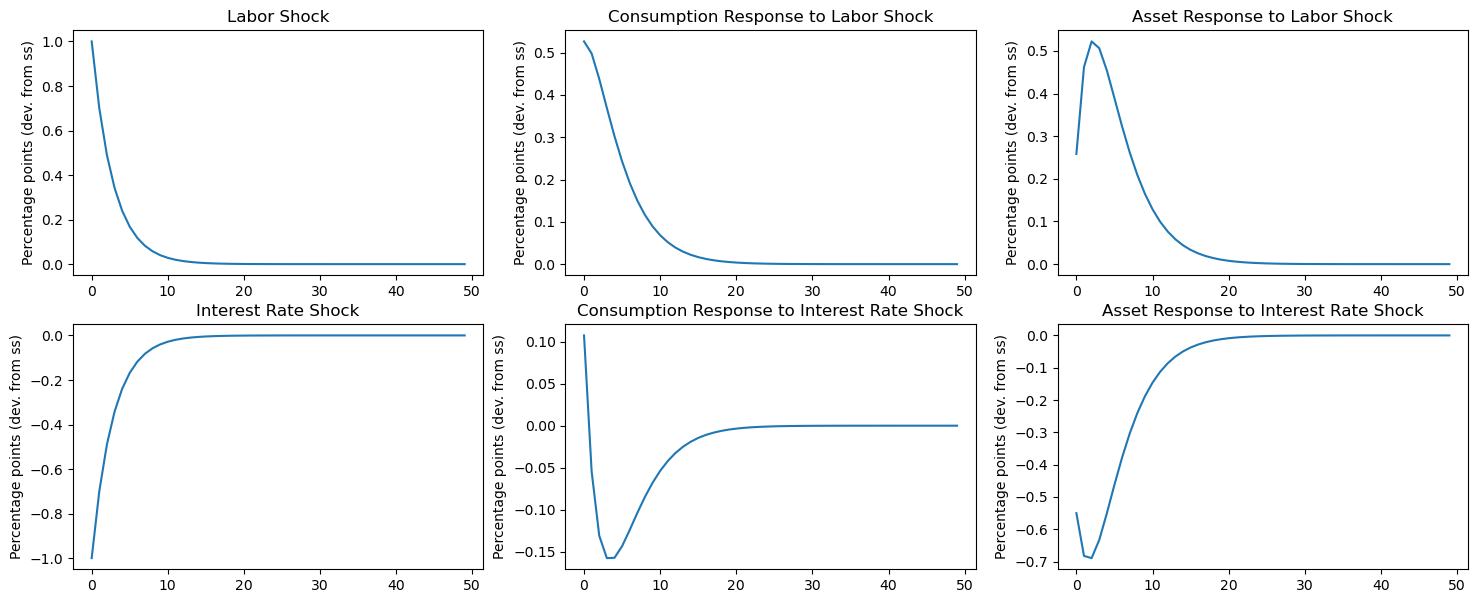

In [11]:
fig, ax = plt.subplots(2,3, figsize=(18, 7))
ax[0, 0].plot(dZ[:50] * 100)
ax[0, 0].set_title("Labor Shock")
ax[0, 1].plot(IRF_CZ[:50] * 100)
ax[0, 1].set_title("Consumption Response to Labor Shock")
ax[0, 2].plot(IRF_AZ[:50] * 100)
ax[0, 2].set_title("Asset Response to Labor Shock")
ax[1, 0].plot(dr[:50] * 100)
ax[1, 0].set_title("Interest Rate Shock")
ax[1, 1].plot(IRF_Cr[:50] * 100)
ax[1, 1].set_title("Consumption Response to Interest Rate Shock")
ax[1, 2].plot(IRF_Ar[:50] * 100)
ax[1, 2].set_title("Asset Response to Interest Rate Shock")
for ax in ax.flat:
    ax.set(ylabel='Percentage points (dev. from ss)')
plt.show()

# Step 2: Add General Equilibrium Blocks using SSJ

## 1. Set Up General Equilibrium Blocks
For this demonstration, we use the simple model from ['HANK with Fiscal Policy'](https://github.com/shade-econ/nber-workshop-2022/blob/main/Tutorials/Tutorial%201%20Fiscal%20Policy.ipynb) which includes only a government. Adapting it to firms and monetary policy should be straight forward.

In [12]:
@sj.simple
def fiscal(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B  # total tax burden
    Z = Y - T  # after tax income
    deficit = G - T
    
    return T, Z, deficit

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    
    return asset_mkt, goods_mkt

## 2. Compute Impulse Response Functions
We have two options to create IRFs. We can use the SSJ build-in functions or combine partial equilibrium jacobians by hand.

### 2.1 Using SSJ for impulse response functions
The faster and more realiable way to get IRFs is to create a model replacing the `HetBlock` with the HARK Jacobian Dictionary and use the HARK Steady State Dictionary when needed. This ensures that the DAG-structure remains in place, meaning SSJ knows exactly which Jacobians to combine. Note that all other functions remain untouched. 

In [13]:
# Create the model and specify attributes
HARK_HANK = create_model([HARK_Jacobian_Dict, fiscal, mkt_clearing], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['G']

In [14]:
# First, we analyze a government spending shock.
G_std = .01
G_persistence = .8
dG =  G_std * G_persistence**np.arange(T)
shocks_G = {"G": dG}

In [15]:
# Create the IRFs
irfs_G = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_G)

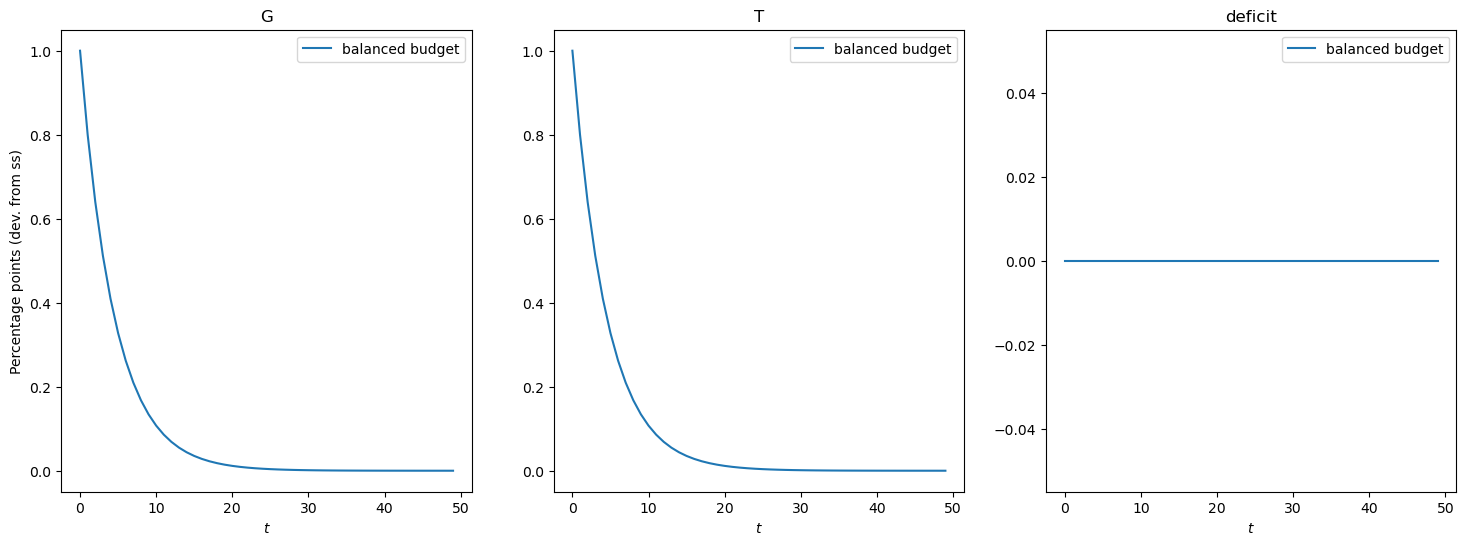

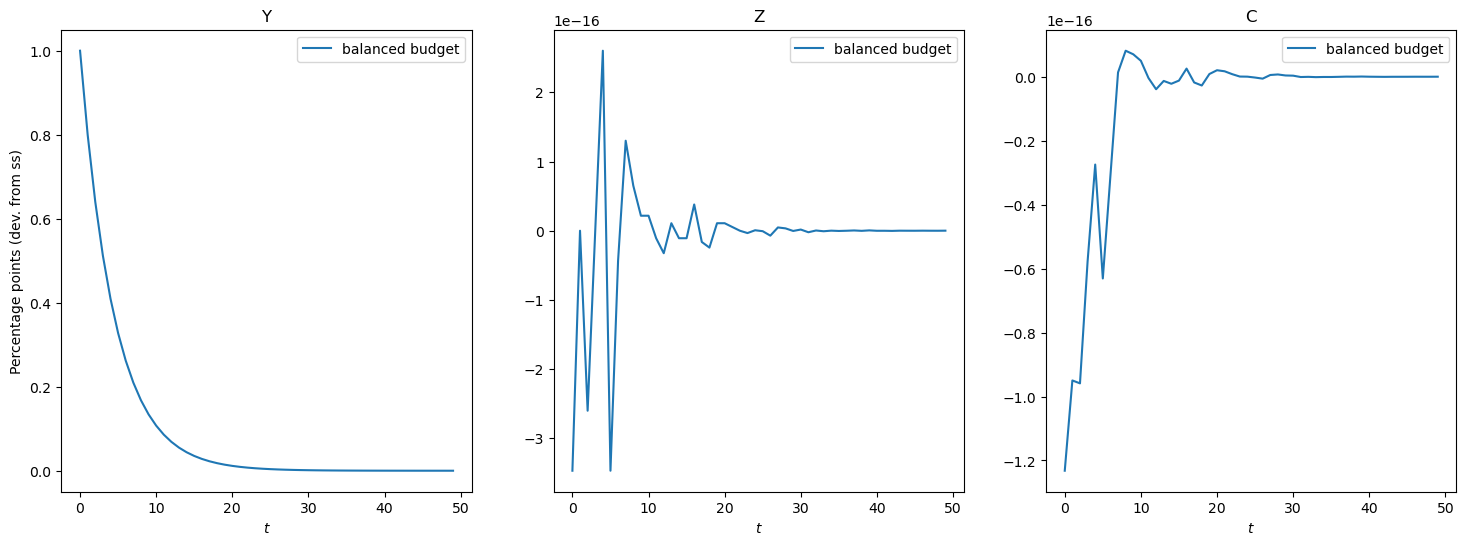

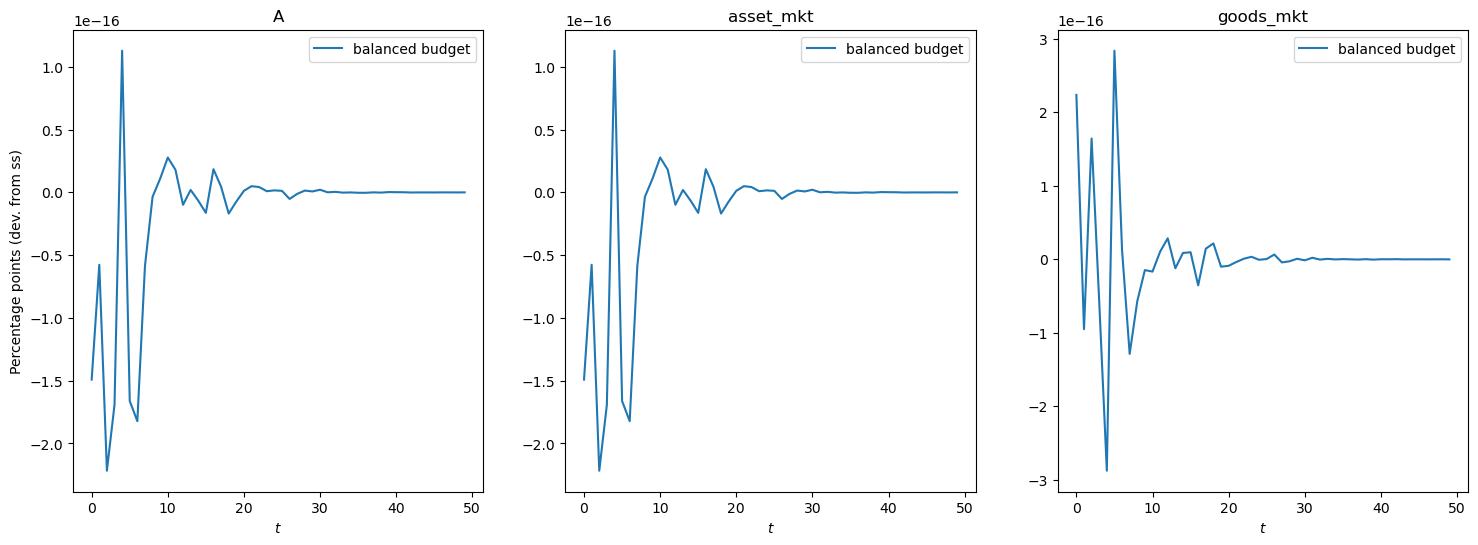

In [16]:
# Plot them
show_irfs([irfs_G], ['G', 'T', 'deficit'], labels=["balanced budget"])
show_irfs([irfs_G], ['Y', 'Z', 'C'], labels=["balanced budget"])
show_irfs([irfs_G], ['A','asset_mkt', 'goods_mkt'], labels=["balanced budget"])

### Analysing a Deficit financed Government spending shock
You can simply change the shock you want to analyze.

In [17]:
# Deficit Spending
rho_B = 0.8
dB = np.cumsum(dG) * rho_B ** np.arange(T)
shocks_B = {'G': dG, 'B': dB}

irfs_B = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_B)

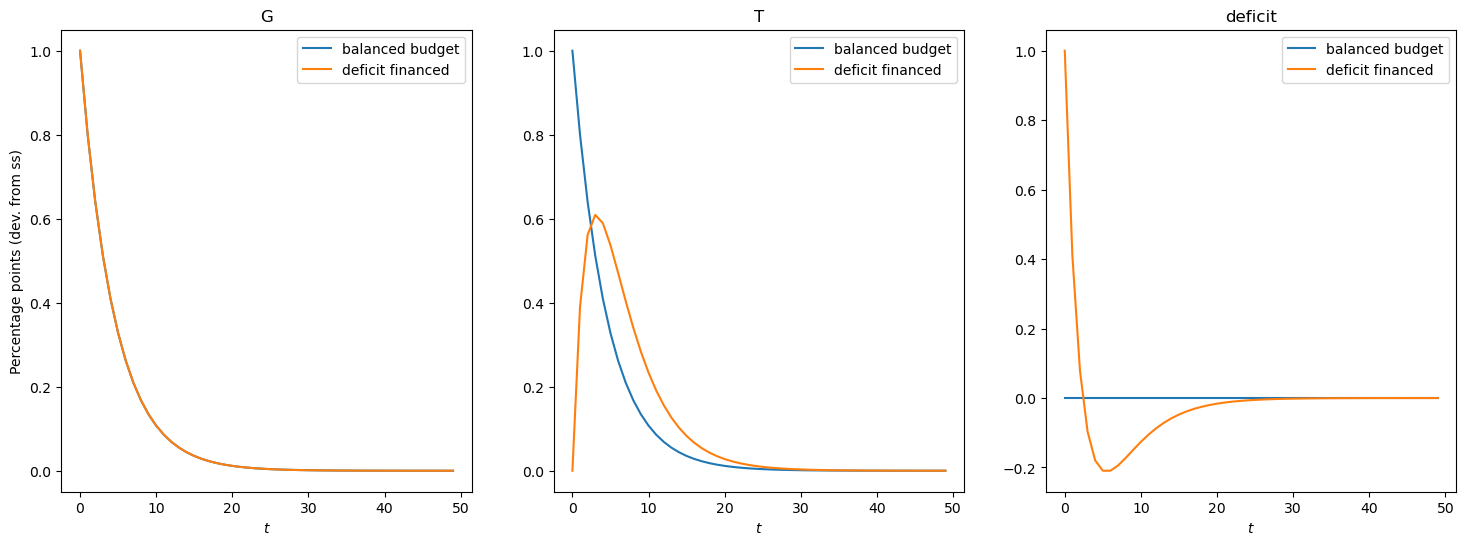

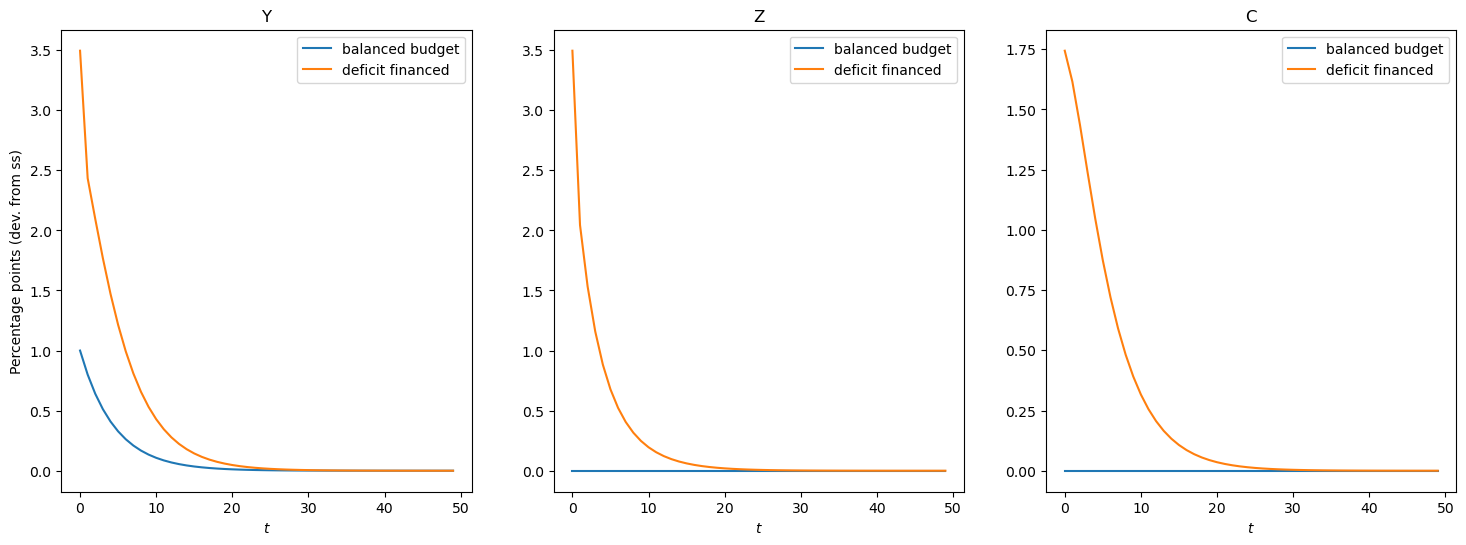

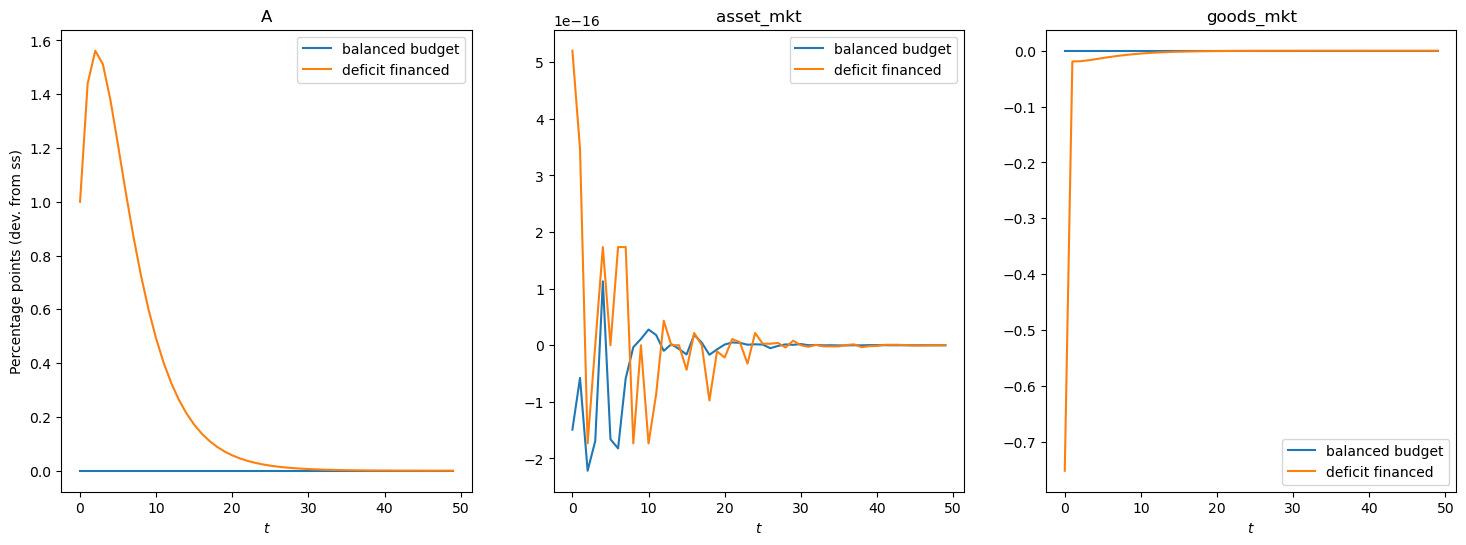

In [18]:
show_irfs([irfs_G, irfs_B], ['G', 'T', 'deficit'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_G, irfs_B], ['Y', 'Z', 'C'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_G, irfs_B], ['A', 'asset_mkt', 'goods_mkt'], labels=["balanced budget", "deficit financed"])

### Analysing an Interest rate shock

In [19]:
# Interest rate shock
dr = -0.01 * 0.7 ** np.arange(T)
shocks_r = {'r': dr}    

In [20]:
irfs_r = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_r)

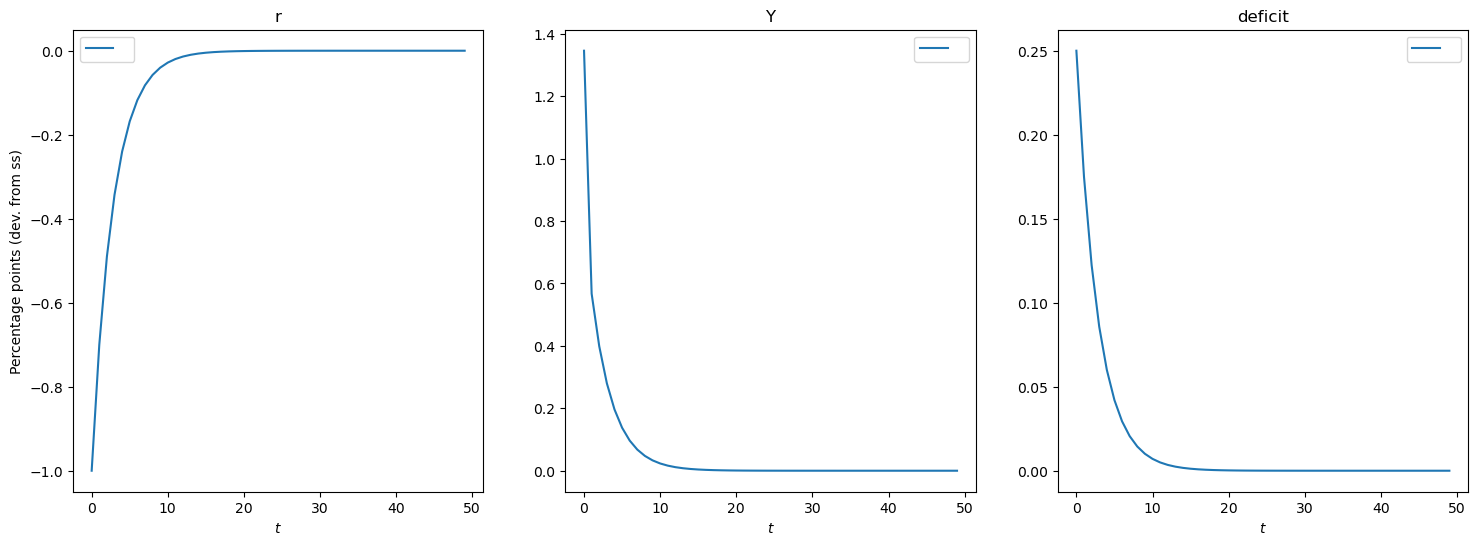

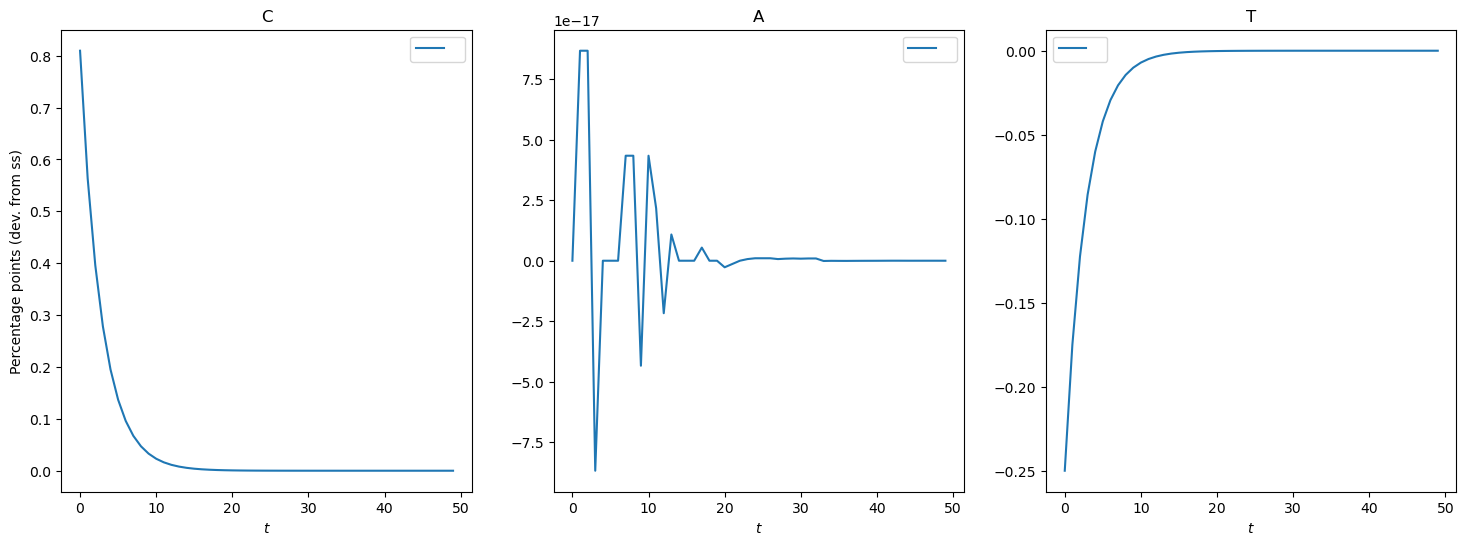

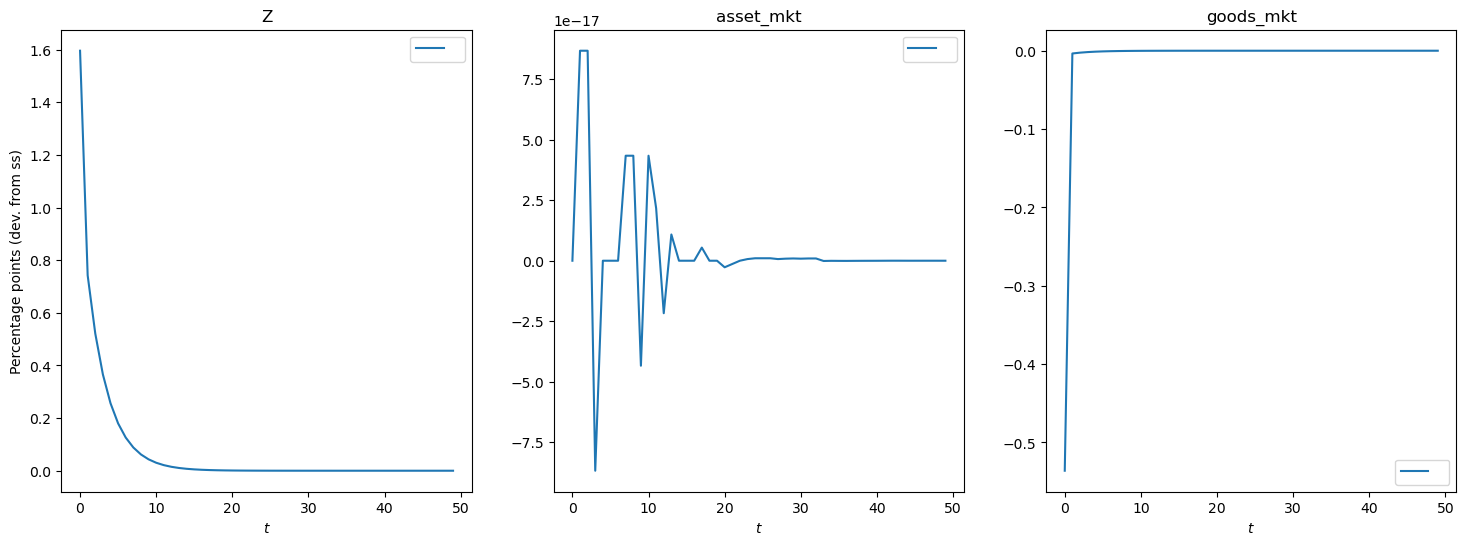

In [21]:
show_irfs([irfs_r], ['r', 'Y', 'deficit'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_r], ['C', 'A', 'T'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_r], ['Z', 'asset_mkt', 'goods_mkt'], labels=["balanced budget", "deficit financed"])

### 2.2 Combining partial equilibrium Jacobians by Hand
As the HARK Jacobian Dictionary is written in the class of a `JacobianDict` from SSJ, you can combine jacobians by hand.

For this, use the SSJ function `jacobians` and specify the HARK steady state dictionary to obtain jacobians from other blocks. This exercise might be useful to decompose direct and indirect effects of a shock (see [Monetary Policy Notebook](https://github.com/shade-econ/nber-workshop-2022/blob/main/Tutorials/Tutorial%202%20Monetary%20Policy.ipynb))

In [22]:
J_fiscal = fiscal.jacobian(HARK_SteadyState_Dict, inputs=['B', 'G', 'Y'])

In [23]:
J_fiscal

<JacobianDict outputs=['T', 'Z', 'deficit'], inputs=['B', 'G', 'Y']>

In [24]:
HARK_Jacobian_Dict['C']['Z'] @ J_fiscal['Z']['G']

array([[-2.67956398e-01, -2.03986108e-01, -1.30132653e-01, ...,
        -2.96758366e-13, -2.96758366e-13, -2.96758366e-13],
       [-1.67203332e-01, -2.67956398e-01, -1.59532439e-01, ...,
        -2.00091530e-13, -2.00091530e-13, -2.00091530e-13],
       [-1.15449994e-01, -1.67203332e-01, -2.38161180e-01, ...,
        -1.37249918e-13, -1.37249918e-13, -1.37249918e-13],
       ...,
       [ 1.29896094e-10, -2.33143697e-14, -4.46514908e-14, ...,
        -2.13453294e-01, -1.24591119e-01, -8.13437318e-02],
       [ 1.29896094e-10, -2.33143697e-14, -4.46514908e-14, ...,
        -1.29728812e-01, -2.13453294e-01, -1.24591119e-01],
       [ 1.29896094e-10, -2.33143697e-14, -4.46514908e-14, ...,
        -8.94205935e-02, -1.29728812e-01, -2.13453294e-01]])

# Summary
This notebook explained how easy it is to combine the benefits of HARK and SSJ. HARK allows you to analyze the partial equilibium case and tweak your model such that the heterogeneous block behaves as intendend, while SSJ helps you to specify the general equilibrium blocks and combine jacobians such that you can plot impluse response functions.